**Caleb and Florance**

Spring 2023

CS 443: Bio-inspired Machine Learning

#### Week 1: Neural decoders

# Project 1: Hebbian Learning

This week you will build two different single-layer neural networks (<b>"decoders"</b>) for supervised learning in TensorFlow:
1. linear softmax neural network — essentially the one in your MLP project from CS 343.
2. nonlinear MLP implemented in Tensorflow that uses a new activation function (hyperbolic tangent).

Next week, you will uses these decoding networks to see how accurately you can decode the class (int 0-9) from neural activations generated by a bio-inspired Hebbian neural network to each image in the MNIST handwritten dataset (this is like *"mind reading"*!). **For now, let's ignore this part** and assume that the above two neural networks that you implement will process the MNIST data directly (reshaped to the usual `(N, M)` for MLPs).

**Important notes:**
1. Your challenge is to implement `neural_decoder.py` **only with TensorFlow, no Numpy**. In other words, you should **not** import numpy at the top of `neural_decoder.py`. The reason for this is to encourage practice with the TensorFlow API.
2. Your implementation in of both networks should only use the TensorFlow low-level API (no Keras).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

## Task 1: Linear softmax decoder

The linear decoder is a single-layer softmax network. At the implementation level there is nothing different about this network than what you built last semester. This warm-up task will allow you to practice design skills that you have developed in CS 343 and apply them to a new situation. 

**Reminder:** This network should be built using TensorFlow only (no Numpy).

In [6]:
from neural_decoder import NeuralDecoder

### 1a. Neural decoder shared functionality: basics

Start by implementing methods that both the linear and nonlinear decoders will share in the `NeuralDecoder` class (`neural_decoder.py`). Use the below test code to help you along.

- Constructor
- `get_wts(self)`
- `get_b(self)`
- `set_wts(self)`
- `set_b(self)`
- `one_hot(self, y, C, off_value=0)`
- `accuracy(self, y_true, y_pred)`

#### Test: weight and bias initialization

In [3]:
tf.random.set_seed(0)
M, C = 3, 2
nl = NeuralDecoder(M, C, wt_stdev=0.01)
wts = nl.get_wts()
b = nl.get_b()
print(f"Your wts are:\n{wts}\nand should be:")
print("""<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.015,  0.004],
       [-0.004, -0.01 ],
       [-0.012,  0.005]], dtype=float32)>""")
print(f"\nYour bias is:\n{b}\nand should be")
print("""<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.011, 0.002], dtype=float32)> """)

Your wts are:
<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.015,  0.004],
       [-0.004, -0.01 ],
       [-0.012,  0.005]], dtype=float32)>
and should be:
<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.015,  0.004],
       [-0.004, -0.01 ],
       [-0.012,  0.005]], dtype=float32)>

Your bias is:
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.011, 0.002], dtype=float32)>
and should be
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.011, 0.002], dtype=float32)> 


#### Test: one-hot

In [16]:
C = 5
y = tf.constant([0, 3, 2, 4])
nl = NeuralDecoder(1, C)
print(f'Your one-hot coding of {y} is:')
tf.print(nl.one_hot(y, C))
print('and should be:\n[[1 0 0 0 0]\n [0 0 0 1 0]\n [0 0 1 0 0]\n [0 0 0 0 1]]')

Your one-hot coding of [0 3 2 4] is:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
and should be:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


#### Test: accuracy

In [7]:
nl = NeuralDecoder(1, 1)
y1 = tf.constant([1, 2, 3, 1, 2, 3])
y2 = tf.constant([1, 0, 3, 1, 0, 3])
acc = nl.accuracy(y1, y2)
print(f'Your accuracy is {acc:.2f} and should be 0.67')

Your accuracy is 0.67 and should be 0.67


### 1b. Implement Softmax decoder

Create a class in `neural_decoder.py` called `SoftmaxDecoder` that inherits from `NeuralDecoder`. Implement and test the following methods in your `SoftmaxDecoder` class:
- `forward(self, x):` Do the follow pass with samples `x`. For the softmax network, this is Dense netIn followed by softmax netAct.
- `loss(self, yh, net_act):` Computes cross-entropy loss with true classes `yh` (one-hot coded) and `net_act`.


For cross-entropy loss, you can use the "one-hot version" of the equation (*since true class values $\vec{yh}$ are one-hot coded coming in*):

$$L = -\frac{1}{B} \sum_{i=1}^B \sum_{c=1}^C yh_{ic} \times log(\text{netAct}_{ic})$$

where $B$ is the mini-batch size and $C$ is the number of classes, like usual.

#### Tips
- If you are getting type compatibility problems, try casting to `tf.float32`.

In [17]:
from neural_decoder import SoftmaxDecoder

#### Test forward

In [23]:
N, M, C = 4, 3, 5

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)

sm_net = SoftmaxDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148, 0.3, -0.002], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127, 0.11, 0.12],
                            [ 0.143,  0.04 ,  0.063, -0.11, -0.12],
                            [-0.22 ,  0.189, -0.017, 0.13, 0.14]], dtype=tf.float32))
test_net_act = sm_net.forward(x)

print(f'Your net_act is:\n{test_net_act}')
print(f'and it should be:')
print("""[[0.172 0.209 0.186 0.248 0.185]
 [0.151 0.201 0.138 0.292 0.217]
 [0.181 0.237 0.17  0.237 0.174]
 [0.166 0.193 0.166 0.272 0.203]]""")

Your net_act is:
[[-0.003  0.195  0.078  0.365  0.07 ]
 [-0.278  0.011 -0.365  0.383  0.088]
 [-0.024  0.248 -0.085  0.246 -0.062]
 [-0.105  0.045 -0.109  0.387  0.094]]
and it should be:
[[0.172 0.209 0.186 0.248 0.185]
 [0.151 0.201 0.138 0.292 0.217]
 [0.181 0.237 0.17  0.237 0.174]
 [0.166 0.193 0.166 0.272 0.203]]


#### Test loss

In [25]:
N, M, C = 4, 3, 5

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)

sm_net = SoftmaxDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148, 0.3, -0.002], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127, 0.11, 0.12], \
    [ 0.143,  0.04 ,  0.063, -0.11, -0.12], \
    [-0.22 ,  0.189, -0.017, 0.13, 0.14]], dtype=tf.float32))
test_net_act = sm_net.forward(x)
test_yh = sm_net.one_hot(y, C)
test_loss = sm_net.loss(test_yh, test_net_act)

print(f'Your loss is {test_loss:.4f} and it should be 1.5895')

Your loss is [1.762 1.23  1.771 1.595] and it should be 1.5895


### 1c. Neural decoder shared functionality (`predict`)

Now that you've implemented the specific methods for the softmax decoder, implement the `predict(self, x, net_act=None)` in the `NeuralDecoder` class, which predicts the class of each sample in `x`. This method is common to both the linear and nonlinear decoders (`neural_decoder.py`):

To predict the class of sample `i` $c_i^*$, you can use softmax:
$$c_i^* = argmax_{c}(\text{netAct}_{ic})$$


#### Test `predict`

In [26]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(5)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)

sm_net = SoftmaxDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_preds = sm_net.predict(x)

tf.print(f'Your test predicted classes are {test_preds} and they should be [1 0 1 1]')

Your test predicted classes are [1 0 1 1] and they should be [1 0 1 1]


### 1d. Neural decoder shared functionality (`fit` with early stopping)

To make determining a reasonable number of training epochs less of a chore, implement training with **early stopping**: train and regularly monitor loss on the validation set. If the network has not "broken a new record" in making the validation loss smaller over the recent history, stop training the network. We also limit training to some maximum number of epochs in case we do not stop early to prevent the network possibly training for an unreasonably long time. The number of validation loss values in the recent history that we consider when deciding whether to stop training early is called the **patience**.

#### Todo

Implement the following training related methods in the `NeuralDecoder` class (`neural_decoder.py`). These methods are shared among all types of decoder networks (linear, nonlinear).

- `early_stopping(self, recent_val_losses, curr_val_loss, patience)`: Update rolling list of recent validation loss values with the validation loss computed on the current epoch. Return whether we should stop training based on the `patience` hyperparameter value.
- `extract_at_indices(self, x, indices)`: small helper method to return the samples or labels (`x`) at the indices `indices`. Useful for forming mini-batches during training.
- `fit(self, x, y, x_val=None, y_val=None, mini_batch_sz=512, lr=1e-4, max_epochs=1000, patience=3, val_freq=1, verbose=True)`

#### Test `early_stopping`

In [10]:
sd = SoftmaxDecoder(1, 1)

# Test 1
patience_1 = 5
es_lost_hist_1 = []
for iter in range(10):
    curr_loss = float(iter)
    es_lost_hist_1, stop = sd.early_stopping(es_lost_hist_1, curr_loss, patience=patience_1)

    if stop:
        break
print(f'Early stopping Test 1 ({patience_1=}):\n Stopped after {iter} iterations (should be 5 iterations).')
print(f' Recent loss history is {es_lost_hist_1} and should be [1.0, 2.0, 3.0, 4.0, 5.0]')
print()

# Test 2
tf.random.set_seed(1)
patience_2 = 3
es_lost_hist_2 = []
test_2_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_2_loss_vals[iter]
    es_lost_hist_2, stop = sd.early_stopping(es_lost_hist_2, curr_loss, patience=patience_2)

    if stop:
        break
print(f'Early stopping Test 2 ({patience_2=}):\n Stopped after {iter} iterations (should be 6 iterations).')
print(f' Recent loss history is {es_lost_hist_2} and should be [0.29193902, 0.64250207, 0.9757855]')
print()

# Test 3
tf.random.set_seed(1)
patience_3 = 6
es_lost_hist_3 = []
test_3_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_3_loss_vals[iter]
    es_lost_hist_3, stop = sd.early_stopping(es_lost_hist_3, curr_loss, patience=patience_3)

    if stop:
        break
print(f'Early stopping Test 3 ({patience_3=}):\n Stopped after {iter} iterations (should be 9 iterations).')
print(f' Recent loss history is\n {es_lost_hist_3}\n and should be')
print(f' [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]')
print()



Early stopping Test 1 (patience_1=5):
 Stopped after 5 iterations (should be 5 iterations).
 Recent loss history is [1.0, 2.0, 3.0, 4.0, 5.0] and should be [1.0, 2.0, 3.0, 4.0, 5.0]

Early stopping Test 2 (patience_2=3):
 Stopped after 6 iterations (should be 6 iterations).
 Recent loss history is [0.29193902, 0.64250207, 0.9757855] and should be [0.29193902, 0.64250207, 0.9757855]

Early stopping Test 3 (patience_3=6):
 Stopped after 9 iterations (should be 9 iterations).
 Recent loss history is
 [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]
 and should be
 [0.29193902, 0.64250207, 0.9757855, 0.43509948, 0.6601019, 0.60489583]



#### Test `extract_at_indices`

In [27]:
sd = SoftmaxDecoder(1, 1)

# Test 1
test_samples = tf.reshape(tf.range(100, dtype=tf.float32), [25, 4])
test_1_inds = tf.constant([0, 10, 2])
test_1_vals = sd.extract_at_indices(test_samples, test_1_inds)
print(f'Test 1:\n-------\n {test_1_vals=}\n and should be')
print(""" test_1_vals=<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [40., 41., 42., 43.],
       [ 8.,  9., 10., 11.]], dtype=float32)>""")

# Test 2
tf.random.set_seed(0)
test_labels = tf.random.shuffle(tf.range(10))
test_2_inds = tf.constant([1, 2, 3, 4])
test_2_vals = sd.extract_at_indices(test_labels, test_2_inds)
print(f'Test 2:\n-------\n {test_2_vals=}\n and should be')
print(""" test_2_vals=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([9, 1, 2, 7], dtype=int32)>""")


Test 1:
-------
 test_1_vals=<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [40., 41., 42., 43.],
       [ 8.,  9., 10., 11.]], dtype=float32)>
 and should be
 test_1_vals=<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [40., 41., 42., 43.],
       [ 8.,  9., 10., 11.]], dtype=float32)>
Test 2:
-------
 test_2_vals=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([9, 1, 2, 7], dtype=int32)>
 and should be
 test_2_vals=<tf.Tensor: shape=(4,), dtype=int32, numpy=array([9, 1, 2, 7], dtype=int32)>


#### Test `fit`

Write code in the cell below to:
- Load in Iris training and validation sets (as you have done above for your softmax classifier). For this test, **don't** do any preprocessing (e.g. no normalization).
- Make sure that your train and validation samples are `tf.float32`.
- Create and train a softmax decoder network using the hyperparameters provided below.
- Make a well-labeled plot showing the validation loss over training epochs.

If everything is working as expected, your validation accuracy should reach ~98% by the end of training and the validation loss should reach ~0.08. Everyone's epochs until early stopping might be different. Mine stopped after 700 epochs.

You may use Numpy as needed when writing code in this notebook.

Suggested information to include in training progress print outs (**note:** the numbers below are fake placeholders):

```
Epoch 0/4999, Training loss 10.00, Val loss 5.00, Val acc 10.00
Epoch 100/4999, Training loss 9.00, Val loss 4.00, Val acc 15.00
```

In [69]:
tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
x = np.load('iris_train_samps.npy')
y = np.load('iris_train_labels.npy')
print(f'{x.shape = }')
print(f'{y.shape = }')

x_val = np.load('iris_val_samps.npy')
y_val = np.load('iris_val_labels.npy')
print(f'{x_val.shape = }')
print(f'{y_val.shape = }')
sd = SoftmaxDecoder(4, 3)

train_loss, val_loss, n = sd.fit(x, y, x_val, y_val, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=100)


x.shape = (100, 4)
y.shape = (100,)
x_val.shape = (49, 4)
y_val.shape = (49,)
Epoch 0/4999 completed 
 1 epoch took 0.06 seconds. Expected runtime is 300.67 seconds.
Epoch 100/4999 completed, took 0.01 seconds. Approx. 73 seconds remain.
Epoch 200/4999 completed, took 0.01 seconds. Approx. 67 seconds remain.
Epoch 300/4999 completed, took 0.02 seconds. Approx. 72 seconds remain.
Epoch 400/4999 completed, took 0.01 seconds. Approx. 65 seconds remain.
Epoch 500/4999 completed, took 0.01 seconds. Approx. 56 seconds remain.
Epoch 600/4999 completed, took 0.01 seconds. Approx. 55 seconds remain.
Epoch 700/4999 completed, took 0.02 seconds. Approx. 67 seconds remain.
Epoch 800/4999 completed, took 0.01 seconds. Approx. 58 seconds remain.
Epoch 900/4999 completed, took 0.01 seconds. Approx. 54 seconds remain.
Epoch 1000/4999 completed, took 0.01 seconds. Approx. 50 seconds remain.
Epoch 1100/4999 completed, took 0.01 seconds. Approx. 54 seconds remain.
Epoch 1200/4999 completed, took 0.01 sec

In [70]:
pred = sd.predict(x_val)
acc = sd.accuracy(pred, y_val)
tf.print(acc)

0.65306122448979587


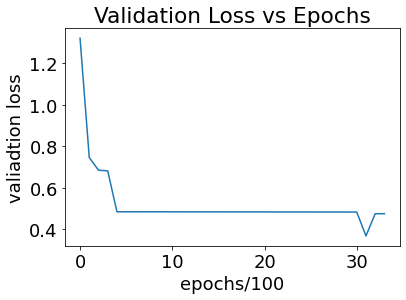

In [74]:
plt.plot(np.linspace(0, len(val_loss)-1, len(val_loss)), val_loss)
plt.xlabel("epochs/100")
plt.ylabel("valiadtion loss")
plt.title("Validation Loss vs Epochs")
plt.show()

### 1e. Questions: Effect of early stopping

**Question 1:** Copy-and-paste your training code from the cell above. Change the `patience` hyperparameter. How do increases and decreases affect the duration of training and **why**?

**Question 2:** Explain how the choice of `patience` affects the risk of overfitting.

**Question 3:** For Iris, does it seem easy or hard to overfit the training set? **What makes you think so?** 

**Answer 1:** As we increase the patience hyperparameter, the duration of training inceases. The opposite happens we decrease the hyperparameter. A larger patience means that we will need more epochs where the loss is constantly increases. Since this is less likely to occur at higher patience values, it is less likely the the network will stop training early. At the very least, more epochs will need to pass until we start checking for overfitting, which will increase training time.

**Answer 2:** As we increase the patience, the risk of overfitting will go up. Since there are more epochs that need to continuously increase, a single random drop could make the training run for many more epochs and cause overfitting.

**Answer 3:** Overfitting seems relatively easy on the iris training set. This is simply due to the small size of the dataset. It seems like with a small sample size, the network could quickly overfit due to seeing the same samples over and over again.

In [44]:
#Question 1:
tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
x = np.load('iris_train_samps.npy')
y = np.load('iris_train_labels.npy')
print(f'{x.shape = }')
print(f'{y.shape = }')

x_val = np.load('iris_val_samps.npy')
y_val = np.load('iris_val_labels.npy')
print(f'{x_val.shape = }')
print(f'{y_val.shape = }')
sd = SoftmaxDecoder(4, 3)

train_loss, val_loss, n = sd.fit(x, y, x_val, y_val, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=100)

pred = sd.predict(x_val)
acc = sd.accuracy(pred, y_val)
tf.print(acc)

x.shape = (100, 4)
y.shape = (100,)
x_val.shape = (49, 4)
y_val.shape = (49,)
Epoch 0/4999 completed 
 1 epoch took 0.05 seconds. Expected runtime is 271.49 seconds.
Epoch 100/4999 completed, took 0.01 seconds. Approx. 45 seconds remain.
Epoch 200/4999 completed, took 0.01 seconds. Approx. 46 seconds remain.
Epoch 300/4999 completed, took 0.01 seconds. Approx. 41 seconds remain.
Epoch 400/4999 completed, took 0.01 seconds. Approx. 40 seconds remain.
Epoch 500/4999 completed, took 0.01 seconds. Approx. 40 seconds remain.
Epoch 600/4999 completed, took 0.01 seconds. Approx. 40 seconds remain.
Epoch 700/4999 completed, took 0.01 seconds. Approx. 41 seconds remain.
Epoch 800/4999 completed, took 0.01 seconds. Approx. 39 seconds remain.
Epoch 900/4999 completed, took 0.01 seconds. Approx. 36 seconds remain.
Epoch 1000/4999 completed, took 0.01 seconds. Approx. 37 seconds remain.
Epoch 1100/4999 completed, took 0.01 seconds. Approx. 35 seconds remain.
Epoch 1200/4999 completed, took 0.01 sec

## Task 2: Nonlinear decoder

Now that you have the softmax decoder implemented, implement in TensorFlow the following nonlinear single layer decoding neural network proposed by Krotov & Hopfield (2019):

$$\text{netIn}_{ic} = \sum_{j=1}^M x_{ij}w_{jc} + b_c$$
$$\text{netAct}_{ic} = tanh(\beta * \text{netIn}_{ic})$$

where:
- the `net_act` function is the hyperbolic tangent function `tanh` (*this is another common net_act function in neural networks*).
- the wts have shape `(M, C)` and the bias has shape `(C,)`.
- the input $x_{ij}$ has the usual shape `(N, M)`.

To predict the class of sample `i` $c_i^*$, use softmax (same as in your softmax network):
$$c_i^* = argmax_{c}(\text{netAct}_{ic})$$

The loss function to minimize is:

$$L = \sum_{i=1}^B \sum_{c=1}^C \left | \text{yh}_{ic} - \text{netAct}_{ic} \right |^m$$

where:
- $\text{yh}_{ic}$ is the one-hot coding of the true class of sample `i`. Remember: because we are using the $tanh$ activation function, the "on" value is `1` (like usual), **but the "off" value is `-1`**.
- The exponent `m` is a hyperparameter. By default we assume `m=6`.
- $|\cdot|$ means absolute value.

### 2a. Implement nonlinear decoder class

Make a class `NonlinearDecoder` in `neural_decoder.py` that inherits from `NeuralDecoder`. Implement the following methods in the `NonlinearDecoder` class.
- `__init__(self, num_features, num_classes, wt_stdev=0.1, beta=0.005, loss_exp=6):` Set instance variables for `beta` ($\beta$) and `loss_exp` ($m$). Extend parent class constructor/exploit inheritance. 
- `one_hot(self, y, C)`
- `forward(self, x)`
- `loss(self, yh, net_act)`

All of these methods should require only a few lines of code each.

In [31]:
from neural_decoder import NonlinearDecoder

#### Test: weight and bias initialization

In [32]:
tf.random.set_seed(1)
M, C = 4, 3
nl = NonlinearDecoder(M, C)
wts = nl.get_wts()
b = nl.get_b()

tf.print(f"Your wts are:\n{wts}\nand it should be:")
print("""<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>""")
tf.print(f"\nYour bias is:\n{b}\nand it should be")
print(f"<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>")

Your wts are:
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>
and it should be:
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>

Your bias is:
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>
and it should be
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.04 , -0.109, -0.006], dtype=float32)>


#### Test forward

In [33]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32) + 100

nl_net = NonlinearDecoder(M, C)
nl_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
nl_net.set_wts(tf.constant([[-0.062,  0.112,  0.127],
                            [ 0.143,  0.04 ,  0.063],
                            [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_net_act = nl_net.forward(x, net_act=True)

print(f'Your net_act is:\n{test_net_act}')
print(f'and it should be:')
print("""[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]""")

Your net_act is:
[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]
and it should be:
[[-0.069  0.17   0.087]
 [-0.071  0.169  0.084]
 [-0.07   0.17   0.086]
 [-0.07   0.169  0.086]]


#### Test loss

In [34]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)
y = np.array([2, 0, 1, 1])

sm_net = NonlinearDecoder(M, C)
sm_net.set_b(tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32))
sm_net.set_wts(tf.constant([[-0.062,  0.112,  0.127],
                            [ 0.143,  0.04 ,  0.063],
                            [-0.22 ,  0.189, -0.017]], dtype=tf.float32))
test_yh = sm_net.one_hot(y, C)
test_net_act = sm_net.forward(x, net_act=True)
test_loss = sm_net.loss(test_yh, test_net_act)

print(f'Your loss is {test_loss:.4f} and it should be 11.9828')

Your loss is 11.9828 and it should be 11.9828


#### Test `fit`

Copy-and-paste your code from above that trains the softmax network on Iris below. Modify the code in the cell below to train your Nonlinear decoder instead and make the same plot of the validation loss.

Use the same training hyperparameters as you used with the softmax network and default values for the β and `m` (loss exponent) hyperparameters. 

If everything is working as expected, your validation accuracy should reach ~98% by the end of training and the validation loss should reach ~42. Everyone's early stopping values might be different. In case it helps to know, mine stopped after 3400 epochs.

In [52]:
tf.random.set_seed(0)  # keep me

# Use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 100  # how often (in epochs) we check the val loss/acc/early stopping

# TODO: Your code here:
x = np.load('iris_train_samps.npy')
y = np.load('iris_train_labels.npy')
print(f'{x.shape = }')
print(f'{y.shape = }')

x_val = np.load('iris_val_samps.npy')
y_val = np.load('iris_val_labels.npy')
print(f'{x_val.shape = }')
print(f'{y_val.shape = }')
nld = NonlinearDecoder(4, 3)

train_loss, val_loss, n = nld.fit(x, y, x_val, y_val, mini_batch_sz=mini_batch_sz, lr=lr, max_epochs=max_epochs, patience=patience, val_every=100)

pred = nld.predict(x_val)
acc = nld.accuracy(pred, y_val)
tf.print(acc)

x.shape = (100, 4)
y.shape = (100,)
x_val.shape = (49, 4)
y_val.shape = (49,)
Epoch 0/4999 completed 
 1 epoch took 0.05 seconds. Expected runtime is 249.85 seconds.
Epoch 100/4999 completed, took 0.01 seconds. Approx. 45 seconds remain.
Epoch 200/4999 completed, took 0.01 seconds. Approx. 45 seconds remain.
Epoch 300/4999 completed, took 0.01 seconds. Approx. 49 seconds remain.
Epoch 400/4999 completed, took 0.01 seconds. Approx. 45 seconds remain.
Epoch 500/4999 completed, took 0.01 seconds. Approx. 43 seconds remain.
Epoch 600/4999 completed, took 0.01 seconds. Approx. 44 seconds remain.
Epoch 700/4999 completed, took 0.01 seconds. Approx. 52 seconds remain.
Epoch 800/4999 completed, took 0.01 seconds. Approx. 49 seconds remain.
Epoch 900/4999 completed, took 0.01 seconds. Approx. 45 seconds remain.
Epoch 1000/4999 completed, took 0.01 seconds. Approx. 53 seconds remain.
Epoch 1100/4999 completed, took 0.01 seconds. Approx. 43 seconds remain.
Epoch 1200/4999 completed, took 0.01 sec

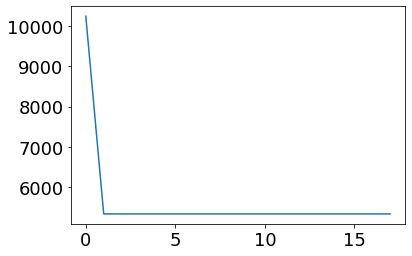

[10251.5244,
 5324.05371,
 5324.05127,
 5324.05176,
 5324.04736,
 5324.04492,
 5324.04492,
 5324.0415,
 5324.04199,
 5324.03711,
 5324.0376,
 5324.03516,
 5324.03613,
 5324.0332,
 5324.04053,
 5324.03125,
 5324.03125,
 5324.04248]


In [67]:
plt.plot(np.linspace(0, len(val_loss)-1, len(val_loss)), val_loss)
plt.xlabel("epochs/100")
plt.ylabel("valiadtion loss")
plt.title("Validation Loss vs Epochs")
plt.show()

### 2b. Effect of β and loss exponent

Make high-quality, well-labeled plots showing:
1. Validation loss over epoch when the nonlinear decoder loss exponent hyperparameter is: 1, 3, 6, 9. There should therefore be 4 curves plotted in the same plot (labeled with legend). Keep β at its default value.
2. Validation loss over epoch when the nonlinear decoder hyperparameter β is: 0.001, 0.005, 0.01. There should therefore be 3 curves plotted in the same plot (labeled with legend). Keep the loss exponent at its default value.

In both cases, set the remaining hyperparameters to the values used in Task 2a above except:
- Set `patience` to 2 and lower `max_epochs` (e.g. to 2000) to speed things up. For this test, it is ok if the network does not stop early (i.e. trains for the full `max_epochs` and then stops).
- Turn off `verbose` so that you do not get any print outs as each decoder is trained.

In [75]:
# Use these parameters
mini_batch_sz = 25
lr = 1e-1
max_epochs = 2000
patience = 2
val_freq = 100  # how often (in epochs) we check the val loss/acc/early stopping


In [99]:
# Effect of loss exponent m
x = np.load('iris_train_samps.npy')
y = np.load('iris_train_labels.npy')
print(f'{x.shape = }')
print(f'{y.shape = }')

x_val = np.load('iris_val_samps.npy')
y_val = np.load('iris_val_labels.npy')
print(f'{x_val.shape = }')
print(f'{y_val.shape = }')

expValLosses = []
for i in [1,3,6,9]:
    nld = NonlinearDecoder(4, 3, loss_exp = i)
    train_loss, val_loss, n = nld.fit(x, y, x_val, y_val, mini_batch_sz=mini_batch_sz, 
                                      lr=lr, max_epochs=max_epochs, patience=patience, val_every=100)
    expValLosses.append(val_loss)
    

x.shape = (100, 4)
y.shape = (100,)
x_val.shape = (49, 4)
y_val.shape = (49,)
Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 24.47 seconds.
Epoch 100/1999 completed, took 0.01 seconds. Approx. 23 seconds remain.
Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 20.57 seconds.
Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 21.23 seconds.
Epoch 100/1999 completed, took 0.01 seconds. Approx. 22 seconds remain.
Epoch 200/1999 completed, took 0.01 seconds. Approx. 17 seconds remain.
Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 22.57 seconds.


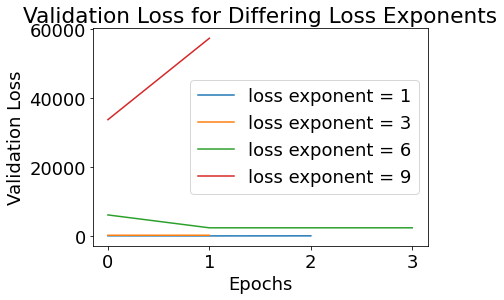

In [100]:
# Make the the plot
plt.plot(np.linspace(0,len(expValLosses[0])-1, len(expValLosses[0])), expValLosses[0], label = "loss exponent = 1")
plt.plot(np.linspace(0,len(expValLosses[1])-1, len(expValLosses[1])), expValLosses[1], label = "loss exponent = 3")
plt.plot(np.linspace(0,len(expValLosses[2])-1, len(expValLosses[2])), expValLosses[2], label = "loss exponent = 6")
plt.plot(np.linspace(0,len(expValLosses[3])-1, len(expValLosses[3])), expValLosses[3], label = "loss exponent = 9")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Differing Loss Exponents")
plt.legend()
plt.show()

In [94]:
# Effect of beta
betaValLosses = []
for i in [0.001, 0.005, 0.01]:
    nld = NonlinearDecoder(4, 3, beta = i)
    train_loss, val_loss, n = nld.fit(x, y, x_val, y_val, mini_batch_sz=mini_batch_sz, 
                                      lr=lr, max_epochs=max_epochs, patience=patience, val_every=100)
    betaValLosses.append(val_loss)

Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 26.10 seconds.
Epoch 100/1999 completed, took 0.01 seconds. Approx. 23 seconds remain.
Epoch 200/1999 completed, took 0.01 seconds. Approx. 18 seconds remain.
Epoch 300/1999 completed, took 0.01 seconds. Approx. 20 seconds remain.
Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 20.24 seconds.
Epoch 0/1999 completed 
 1 epoch took 0.01 seconds. Expected runtime is 27.74 seconds.
Epoch 100/1999 completed, took 0.01 seconds. Approx. 19 seconds remain.


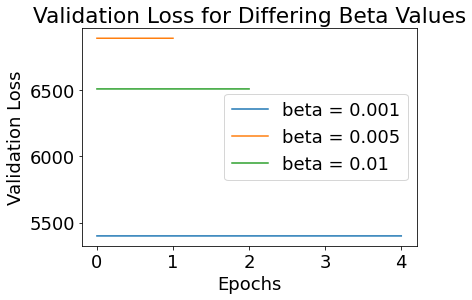

In [98]:
# Make the the plot
plt.plot(np.linspace(0,len(betaValLosses[0])-1, len(betaValLosses[0])), betaValLosses[0], label = "beta = 0.001")
plt.plot(np.linspace(0,len(betaValLosses[1])-1, len(betaValLosses[1])), betaValLosses[1], label = "beta = 0.005")
plt.plot(np.linspace(0,len(betaValLosses[2])-1, len(betaValLosses[2])), betaValLosses[2], label = "beta = 0.01")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Differing Beta Values")
plt.legend()
plt.show()

### 2c. Questions

**Question 4:** Explain what you observe about the effect of the loss exponent `m` on the validation loss. What does it indicate about the quality and speed of learning?

**Question 5:** Explain what you observe about the effect of β on the validation loss. What does it indicate about the quality and speed of learning?

**Answer 4:** As far as I can tell, the loss exponent has very little effect on the validation loss. The expection to that is a loss exponent equal to 9, which causes the loss to explode much higher than any of the other loss exponents did.

**Answer 5:** There is almost a clear pattern for the effect of differing beta values. Generally, it appears that a low beta value cuases validation loss to remain low and slows training down. However, the highest beta value we tested did not have the highest validation or quickest training time. There appears to be a sweetspot in between that has the quickest training time and the hightest validation loss.